In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train,_),(x_test,_) = fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

print(x_train.shape)
print(x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [3]:
x_train = x_train[...,tf.newaxis]
x_test = x_test[...,tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor*tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor*tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy,clip_value_min=0.,clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy,clip_value_min=0.,clip_value_max=1.)

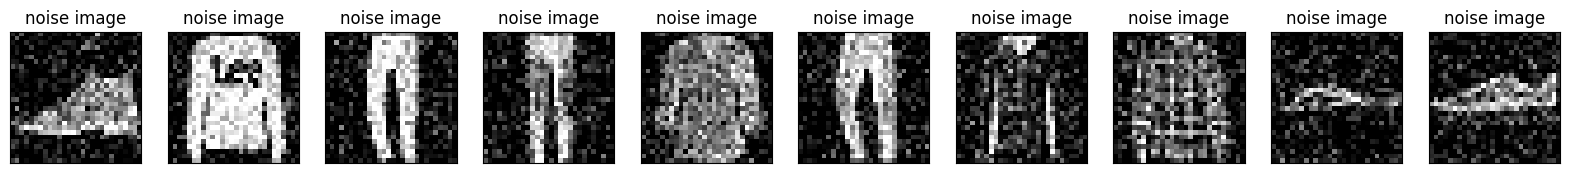

In [6]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
  ax=plt.subplot(1,n,i+1)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title("noise image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


In [7]:
#splotowy autoenkoder odszumiający

class Denoise(Model):
  def __init__(self) -> None:
    super(Denoise,self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16,(3,3),activation='relu',padding='same',strides=2),
        layers.Conv2D(8,(3,3),activation='relu',padding='same',strides=2)
    ])
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8,kernel_size=3,activation='relu',padding='same',strides=2),
        layers.Conv2DTranspose(16,kernel_size=3,activation='relu',padding='same',strides=2),
        layers.Conv2D(1,kernel_size=(3,3),activation='sigmoid',padding='same')
    ])
  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [8]:
autoencoder.compile(optimizer='adam',loss=losses.MeanSquaredError())

In [9]:
autoencoder.fit(x_train_noisy,x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy,x_test))

Epoch 1/10
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0179 - val_loss: 0.0111
Epoch 2/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 3/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 4/10
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 5/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 6/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 7/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 8/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 9/10
1875/1875 [==============================] - 63s 34ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 10/10
1875/1875 [==============================] - 50s 27m

In [10]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
#testowanie autoenkodera na zbiorze testowym
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

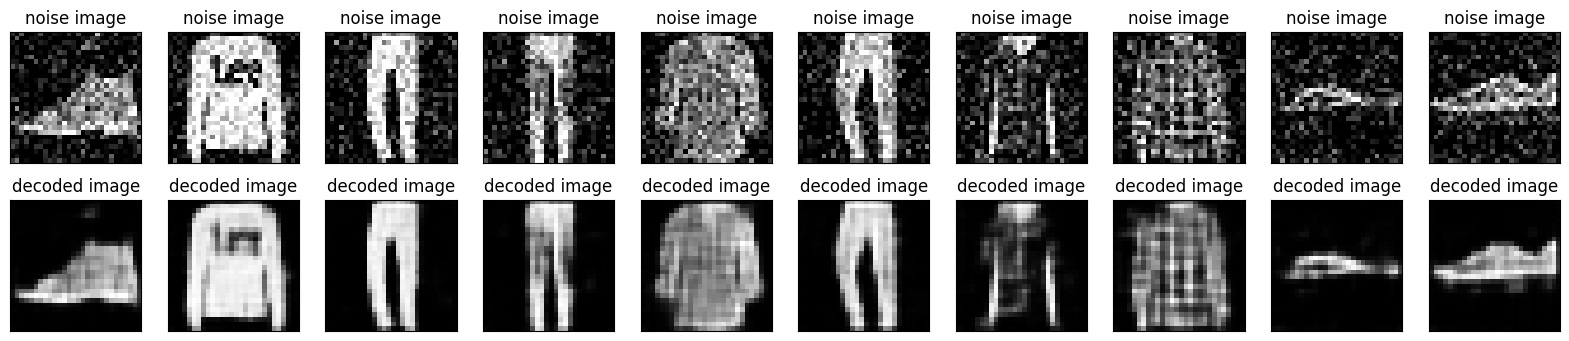

In [15]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  ax=plt.subplot(2,n,i+1)
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.title("noise image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax=plt.subplot(2,n,i+1+n)
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.title("decoded image")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()